<a href="https://colab.research.google.com/github/XawiiQR/TransferLearning/blob/main/TrasnferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.3/306.3 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.0/943.0 kB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 14.6 MB/s eta

In [ ]:
from google.colab import files
files.upload()  # selecciona el archivo kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avelinolupocondori","key":"f4e73b7ac61be5b01b6e9907e8ff5dc2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install kagglehub --quiet

import kagglehub
path = kagglehub.dataset_download("thusharanair/deepfashion2-original-with-dataframes")
print("✅ Dataset descargado en:", path)


100%|██████████| 14.9G/14.9G [02:47<00:00, 95.5MB/s]

Extracting files...


✅ Dataset descargado en: /root/.cache/kagglehub/datasets/thusharanair/deepfashion2-original-with-dataframes/versions/2


Paso 2: Extraer 2000 imágenes (train/val/test) y crear estructura tipo COCO

In [ ]:
!ls deepfashion2_coco/

test  train  val


In [ ]:
import os
import shutil
from pathlib import Path
import random

# ================================
# ⚙️ CONFIGURACIÓN
# ================================
use_all_data = False        # True para usar todas las imágenes
max_images = 2000           # Solo si use_all_data = False

# ✅ Rutas correctas
images_path = Path(path) / "DeepFashion2" / "deepfashion2_original_images" / "train" / "image"
annos_path = Path(path) / "DeepFashion2" / "deepfashion2_original_images" / "train" / "annos"

# ================================
# 📁 CREAR ESTRUCTURA
# ================================
output_dir = Path("/content/deepfashion2_coco")
for split in ['train', 'val', 'test']:
    (output_dir / split / "images").mkdir(parents=True, exist_ok=True)
    (output_dir / split / "annos").mkdir(parents=True, exist_ok=True)

# ================================
# 📦 CARGAR Y DIVIDIR IMÁGENES
# ================================
image_files = list(images_path.glob("*.jpg"))
random.seed(42)
random.shuffle(image_files)

if not use_all_data:
    image_files = image_files[:max_images]

n_total = len(image_files)
split1 = int(0.6 * n_total)
split2 = int(0.8 * n_total)

splits = {
    'train': image_files[:split1],
    'val': image_files[split1:split2],
    'test': image_files[split2:],
}

# ================================
# 📤 COPIAR IMÁGENES Y ANOTACIONES
# ================================
for split, files in splits.items():
    for img_path in files:
        # Copiar imagen
        dest_img = output_dir / split / "images" / img_path.name
        shutil.copy(img_path, dest_img)

        # Copiar anotación si existe
        json_name = img_path.stem + ".json"
        anno_src = annos_path / json_name
        anno_dest = output_dir / split / "annos" / json_name

        if anno_src.exists():
            shutil.copy(anno_src, anno_dest)

print(f"✅ Dataset preparado en: {output_dir}")
print(f"Total: {n_total} imágenes → train: {len(splits['train'])}, val: {len(splits['val'])}, test: {len(splits['test'])}")


✅ Dataset preparado en: /content/deepfashion2_coco
Total: 2000 imágenes → train: 1200, val: 400, test: 400


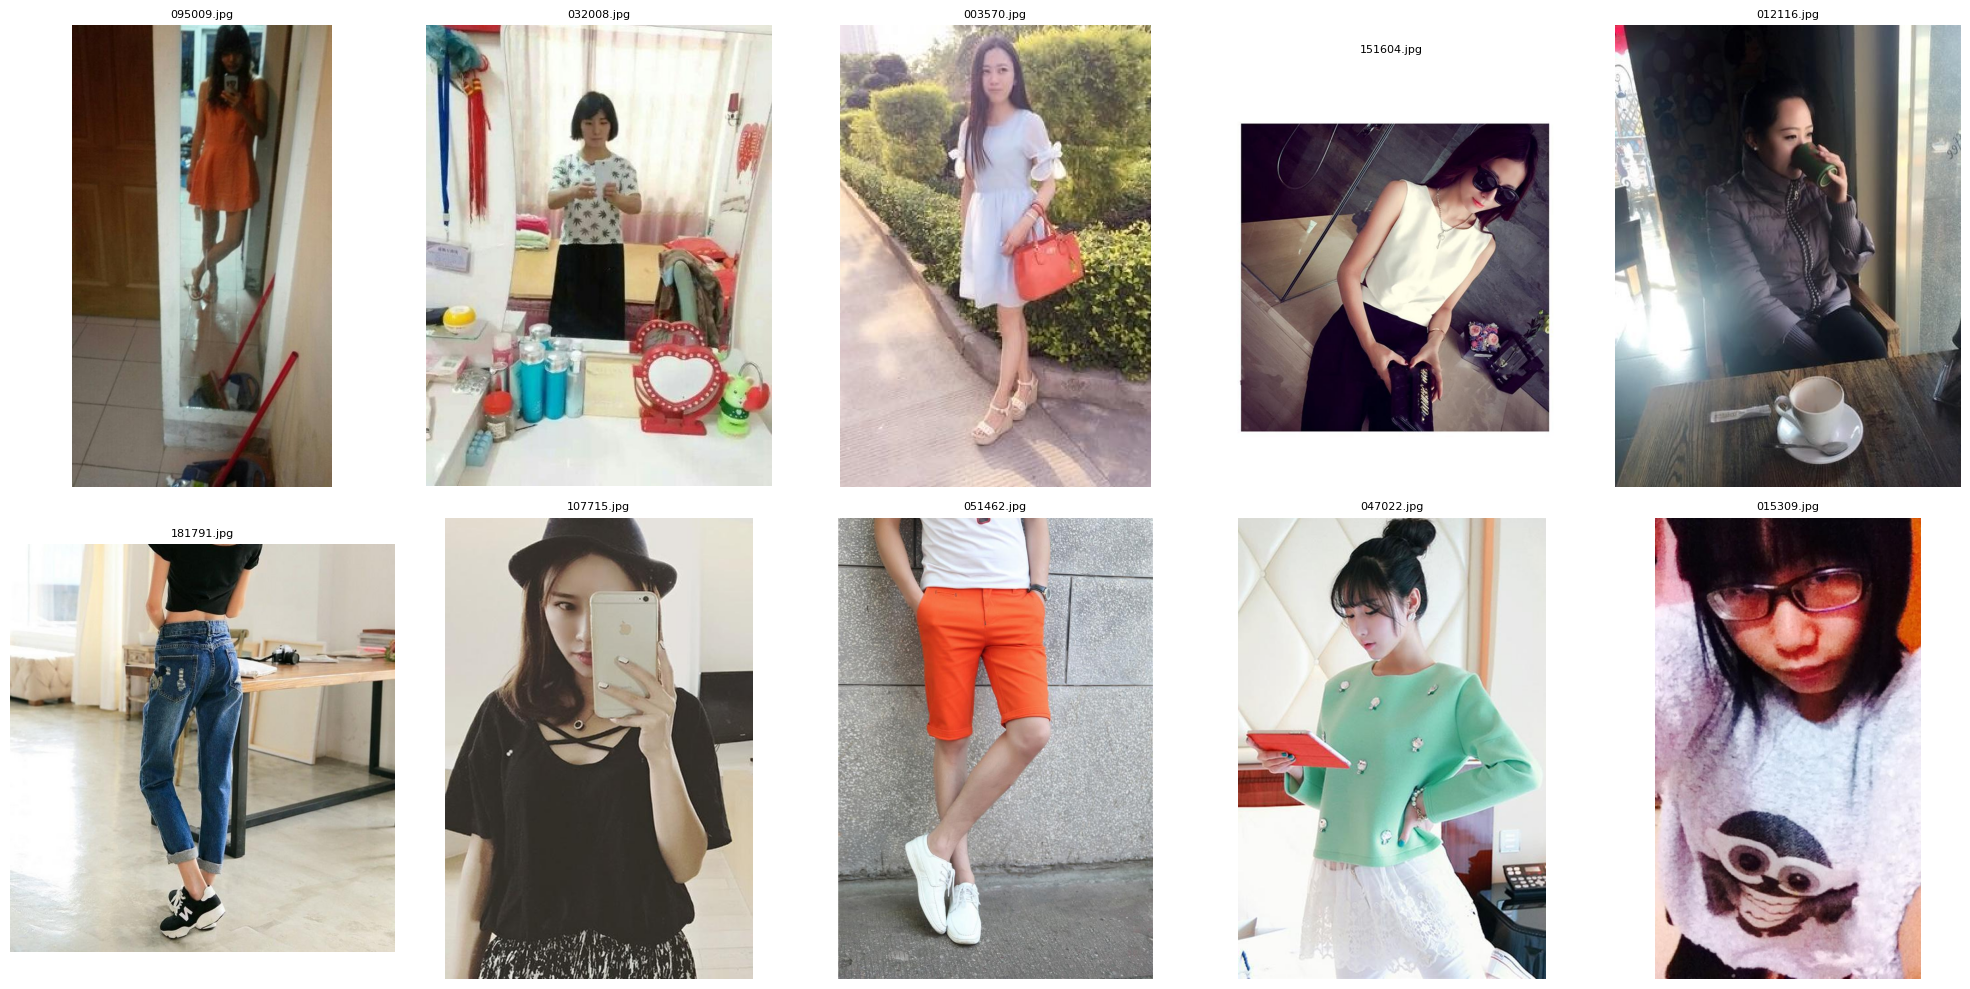

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Split a mostrar
split_to_show = "train"
img_dir = output_dir / split_to_show / "images"
img_paths = list(img_dir.glob("*.jpg"))

# Selección segura
num_images_to_show = min(10, len(img_paths))
if num_images_to_show == 0:
    raise ValueError(f"No se encontraron imágenes en: {img_dir}")

sample_imgs = random.sample(img_paths, num_images_to_show)

# Mostrar con matplotlib
plt.figure(figsize=(20, 10))
for i, img_path in enumerate(sample_imgs):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(img_path.name, fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import torch
import json
import numpy as np
import torchvision.transforms as T
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
import cv2

class DeepFashionDataset(Dataset):
    def __init__(self, image_dir, annos_dir, category_map, transforms=None):
        self.image_dir = Path(image_dir)
        self.annos_dir = Path(annos_dir)
        self.transforms = transforms
        self.category_map = category_map
        self.valid_categories = list(category_map.keys())
        self.label_map = {'upper': 1, 'lower': 2}

        # Filtrar imágenes que tengan su anotación correspondiente
        self.images = [img for img in self.image_dir.glob("*.jpg")
                       if (self.annos_dir / (img.stem + ".json")).exists()]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        ann_path = self.annos_dir / (img_path.stem + ".json")

        # Cargar imagen
        image = Image.open(img_path).convert("RGB")
        width, height = image.size

        # Cargar anotación
        with open(ann_path) as f:
            annos = json.load(f)

        boxes, labels, masks = [], [], []

        # 🔧 Bloque corregido: recorrer solo anotaciones válidas
        for key, item in annos.items():
            if not isinstance(item, dict):
                continue  # saltar si no es un objeto anotación

            category = item.get("category_name", "")
            if category not in self.valid_categories:
                continue

            mapped = self.category_map[category]
            label = self.label_map[mapped]
            bbox = item.get("bounding_box")
            seg = item.get("segmentation")

            if not bbox or not seg or len(seg[0]) < 6:
                continue

            x1, y1, x2, y2 = bbox
            boxes.append([x1, y1, x2, y2])
            labels.append(label)

            # Crear máscara binaria
            mask = np.zeros((height, width), dtype=np.uint8)
            polygon = np.array(seg[0], dtype=np.int32).reshape(-1, 2)
            cv2.fillPoly(mask, [polygon], color=1)
            masks.append(mask)

        # Convertir a tensores
        if not boxes:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0, height, width), dtype=torch.uint8)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target


In [ ]:
# DeepFashion2 categories (según paper)
category_map = {
    "short sleeve top": "upper",
    "long sleeve top": "upper",
    "short sleeve outwear": "upper",
    "long sleeve outwear": "upper",
    "vest": "upper",
    "sling": "upper",
    "dress": "upper",
    "shorts": "lower",
    "trousers": "lower",
    "skirt": "lower"
}

valid_categories = list(category_map.keys())

In [ ]:
# Dataset para entrenamiento
train_dataset = DeepFashionDataset(
    image_dir=output_dir / "train" / "images",
    annos_dir=output_dir / "train" / "annos",
    category_map=category_map,
    transforms=T.ToTensor()
)

# Dataset para validación
val_dataset = DeepFashionDataset(
    image_dir=output_dir / "val" / "images",
    annos_dir=output_dir / "val" / "annos",
    category_map=category_map,
    transforms=T.ToTensor()
)


In [ ]:
import json

example_json_path = output_dir / "train" / "annos" / "000037.json"  # cambia por un archivo que hayas copiado
with open(example_json_path) as f:
    data = json.load(f)

print(type(data))
print(data)


<class 'dict'>
{'source': 'shop', 'pair_id': 5, 'item1': {'segmentation': [[395, 128, 192, 167, 35, 135, 31, 296, 23, 420, 216, 446, 225, 392, 218, 445, 432, 439, 420, 297, 395, 128], [192, 167, 35, 135, 31, 296, 23, 420, 216, 446, 225, 392, 192, 167], [395, 128, 192, 167, 225, 392, 218, 445, 432, 439, 420, 297, 395, 128]], 'scale': 2, 'viewpoint': 2, 'zoom_in': 1, 'landmarks': [35, 135, 1, 192, 167, 2, 395, 128, 1, 31, 296, 2, 23, 420, 2, 216, 446, 2, 225, 392, 2, 218, 445, 2, 432, 439, 2, 420, 297, 2], 'style': 1, 'bounding_box': [21, 125, 439, 487], 'category_id': 7, 'occlusion': 1, 'category_name': 'shorts'}}


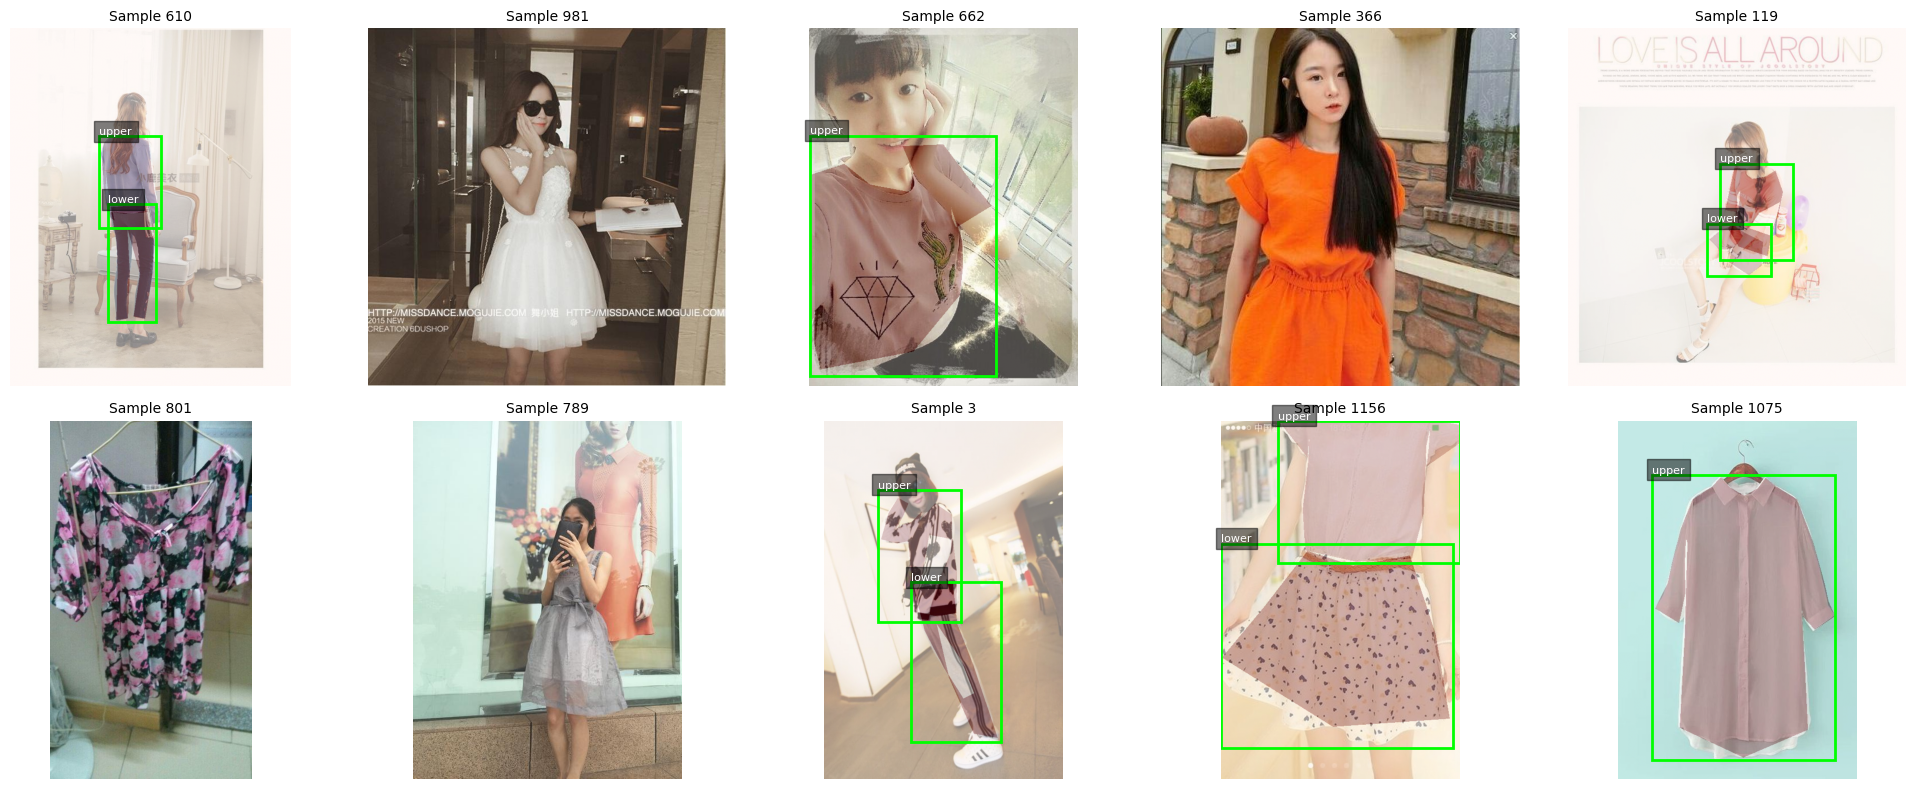

In [ ]:
import matplotlib.pyplot as plt
import random

def show_random_samples(dataset, num_samples=10):
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))  # 2 filas × 5 columnas
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        image, target = dataset[idx]
        image = image.permute(1, 2, 0).numpy()

        ax.imshow(image)

        for i in range(len(target['boxes'])):
            box = target['boxes'][i].numpy()
            label = target['labels'][i].item()
            mask = target['masks'][i].numpy()

            ax.imshow(mask, cmap='Reds', alpha=0.3)

            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

            label_str = 'upper' if label == 1 else 'lower'
            ax.text(x1, y1 - 5, label_str, color='white',
                    bbox=dict(facecolor='black', alpha=0.5), fontsize=8)

        ax.set_title(f"Sample {idx}", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# 🔍 Mostrar 10 ejemplos aleatorios del dataset de entrenamiento
show_random_samples(train_dataset, num_samples=10)


In [ ]:
from pathlib import Path

dataset_path = Path(path)
for p in dataset_path.rglob("*"):
    print(p)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
/root/.cache/kagglehub/datasets/thusharanair/deepfashion2-original-with-dataframes/versions/2/DeepFashion2/deepfashion2_original_images/test/test/image/059311.jpg
/root/.cache/kagglehub/datasets/thusharanair/deepfashion2-original-with-dataframes/versions/2/DeepFashion2/deepfashion2_original_images/test/test/image/021730.jpg
/root/.cache/kagglehub/datasets/thusharanair/deepfashion2-original-with-dataframes/versions/2/DeepFashion2/deepfashion2_original_images/test/test/image/036509.jpg
/root/.cache/kagglehub/datasets/thusharanair/deepfashion2-original-with-dataframes/versions/2/DeepFashion2/deepfashion2_original_images/test/test/image/059539.jpg
/root/.cache/kagglehub/datasets/thusharanair/deepfashion2-original-with-dataframes/versions/2/DeepFashion2/deepfashion2_original_images/test/test/image/052084.jpg
/root/.cache/kagglehub/datasets/thusharanair/deepfashion2-original-with-dataframes/versions/2/DeepFashion2/deepfashion

In [ ]:
from pathlib import Path

jsons = list(Path(path).rglob("*.json"))
print("🔍 JSONs encontrados:")
for j in jsons:
    print(j)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
/root/.cache/kagglehub/datasets/thusharanair/deepfashion2-original-with-dataframes/versions/2/DeepFashion2/deepfashion2_original_images/train/annos/029262.json
/root/.cache/kagglehub/datasets/thusharanair/deepfashion2-original-with-dataframes/versions/2/DeepFashion2/deepfashion2_original_images/train/annos/109323.json
/root/.cache/kagglehub/datasets/thusharanair/deepfashion2-original-with-dataframes/versions/2/DeepFashion2/deepfashion2_original_images/train/annos/022251.json
/root/.cache/kagglehub/datasets/thusharanair/deepfashion2-original-with-dataframes/versions/2/DeepFashion2/deepfashion2_original_images/train/annos/007135.json
/root/.cache/kagglehub/datasets/thusharanair/deepfashion2-original-with-dataframes/versions/2/DeepFashion2/deepfashion2_original_images/train/annos/172866.json
/root/.cache/kagglehub/datasets/thusharanair/deepfashion2-original-with-dataframes/versions/2/DeepFashion2/deepfashion2_original_imag

✅ Paso 3: Entrenamienot del modelo


📦 Epoch 1/5
🔧 Train Loss: 0.6584
✅ Val Loss: 0.5794 | Val Accuracy (IoU>0.5): 0.9859
💾 Mejor modelo guardado en best_maskrcnn.pth

📦 Epoch 2/5
🔧 Train Loss: 0.4955
✅ Val Loss: 0.5300 | Val Accuracy (IoU>0.5): 0.9824
💾 Mejor modelo guardado en best_maskrcnn.pth

📦 Epoch 3/5
🔧 Train Loss: 0.4489
✅ Val Loss: 0.4874 | Val Accuracy (IoU>0.5): 0.9895
💾 Mejor modelo guardado en best_maskrcnn.pth

📦 Epoch 4/5
🔧 Train Loss: 0.4321
✅ Val Loss: 0.4825 | Val Accuracy (IoU>0.5): 0.9912
💾 Mejor modelo guardado en best_maskrcnn.pth

📦 Epoch 5/5
🔧 Train Loss: 0.3983
✅ Val Loss: 0.4713 | Val Accuracy (IoU>0.5): 0.9859
💾 Mejor modelo guardado en best_maskrcnn.pth

🏁 Evaluación Final en Test Set:
🧾 Test Loss: 0.4211 | Test Accuracy (IoU>0.5): 0.9963


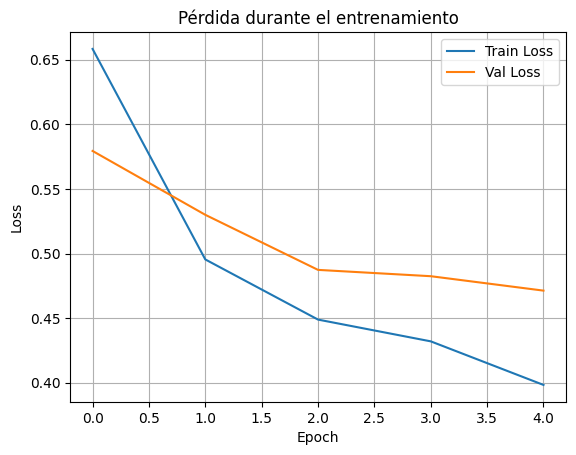

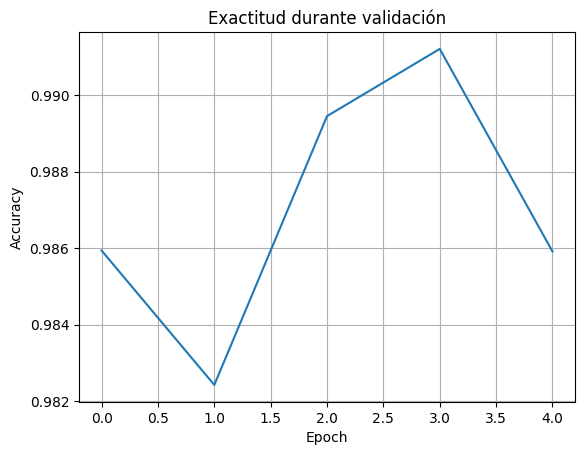

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
from torchvision.ops import box_iou
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# ===========
# ⚙️ CONFIG
# ===========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 3  # background + upper + lower
num_epochs = 5
save_path = "best_maskrcnn.pth"

# ===========
# 📦 Dataset
# ===========
def get_transform():
    return torchvision.transforms.Compose([ToTensor()])

train_dataset = DeepFashionDataset(
    image_dir=output_dir / "train" / "images",
    annos_dir=output_dir / "train" / "annos",
    category_map=category_map,
    transforms=get_transform()
)

val_dataset = DeepFashionDataset(
    image_dir=output_dir / "val" / "images",
    annos_dir=output_dir / "val" / "annos",
    category_map=category_map,
    transforms=get_transform()
)

test_dataset = DeepFashionDataset(
    image_dir=output_dir / "test" / "images",
    annos_dir=output_dir / "test" / "annos",
    category_map=category_map,
    transforms=get_transform()
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# ===========
# 🧠 Modelo
# ===========
model = maskrcnn_resnet50_fpn(pretrained=True)
for name, param in model.backbone.body.named_parameters():
    param.requires_grad = False  # puedes quitar esto si quieres entrenar todo

# Reemplazar cabeza
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes)
in_mask_features = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
    in_mask_features, 256, num_classes)

model.to(device)

# ===========
# 🧮 Optimizer
# ===========
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# ===========
# 🧪 Evaluador
# ===========
def evaluate_model(model, dataloader, device, iou_threshold=0.5):
    model.eval()
    total, correct = 0, 0
    total_loss = 0.0

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Calcular pérdida
            model.train()
            loss_dict = model(images, targets)
            model.eval()
            if isinstance(loss_dict, list):
                continue
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

            # Predicciones
            outputs = model(images)
            for pred, target in zip(outputs, targets):
                if len(pred['boxes']) == 0 or len(target['boxes']) == 0:
                    continue
                ious = box_iou(pred['boxes'].cpu(), target['boxes'].cpu())
                max_ious = ious.max(dim=0).values
                correct += (max_ious > iou_threshold).sum().item()
                total += len(target['boxes'])

    accuracy = correct / total if total > 0 else 0.0
    avg_loss = total_loss / len(dataloader)
    return accuracy, avg_loss

# ===========
# 🔁 Entrenamiento
# ===========
best_val_loss = float("inf")
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    print(f"\n📦 Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss = 0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"🔧 Train Loss: {avg_train_loss:.4f}")

    # 📊 Validación
    val_acc, val_loss = evaluate_model(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"✅ Val Loss: {val_loss:.4f} | Val Accuracy (IoU>0.5): {val_acc:.4f}")

    # 💾 Guardar mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print(f"💾 Mejor modelo guardado en {save_path}")

# ===========
# 🧪 Evaluación final en test
# ===========
print("\n🏁 Evaluación Final en Test Set:")
model.load_state_dict(torch.load(save_path))
test_acc, test_loss = evaluate_model(model, test_loader, device)
print(f"🧾 Test Loss: {test_loss:.4f} | Test Accuracy (IoU>0.5): {test_acc:.4f}")

# ===========
# 📈 Visualización de métricas
# ===========
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Pérdida durante el entrenamiento")
plt.grid()
plt.show()

plt.plot(val_accuracies, label="Val Accuracy (IoU>0.5)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Exactitud durante validación")
plt.grid()
plt.show()


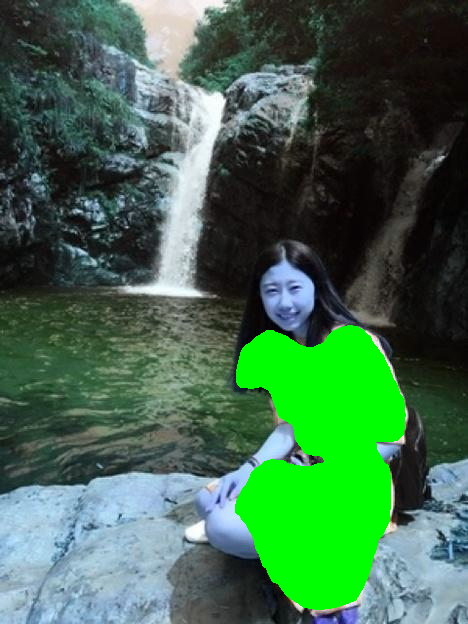

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Imagen de prueba
model.eval()
image, _ = val_dataset[0]
with torch.no_grad():
    prediction = model([image.to(device)])

# Visualizar
img_np = image.mul(255).permute(1, 2, 0).byte().cpu().numpy().copy()
for i, mask in enumerate(prediction[0]['masks']):
    score = prediction[0]['scores'][i].item()
    if score < 0.7:
        continue
    m = mask[0].mul(255).byte().cpu().numpy()
    img_np[m > 127] = (0, 255, 0)  # máscara en verde

cv2_imshow(img_np)


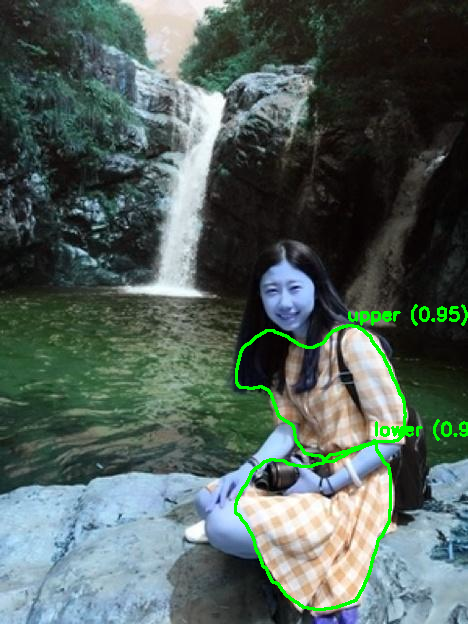

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Modo evaluación
model.eval()

# Obtener una imagen de validación
image, _ = val_dataset[0]

# Inferencia
with torch.no_grad():
    prediction = model([image.to(device)])

# Convertir imagen a formato visualizable
img_np = image.mul(255).permute(1, 2, 0).byte().cpu().numpy().copy()

# Visualizar predicciones
for i, mask in enumerate(prediction[0]['masks']):
    score = prediction[0]['scores'][i].item()
    label_id = prediction[0]['labels'][i].item()

    if score < 0.7:
        continue

    # Nombre de la clase
    label_str = "upper" if label_id == 1 else "lower" if label_id == 2 else "unknown"

    # Máscara binaria
    m = mask[0].mul(255).byte().cpu().numpy()
    contours, _ = cv2.findContours((m > 127).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Dibujar contorno en verde
    cv2.drawContours(img_np, contours, -1, (0, 255, 0), 2)

    # Obtener punto para el texto
    if contours and len(contours[0]) > 0:
        x, y = contours[0][0][0]
        text = f"{label_str} ({score:.2f})"
        cv2.putText(img_np, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 255, 0), 2)

# Mostrar imagen
cv2_imshow(img_np)


In [ ]:
!pip install webcolors


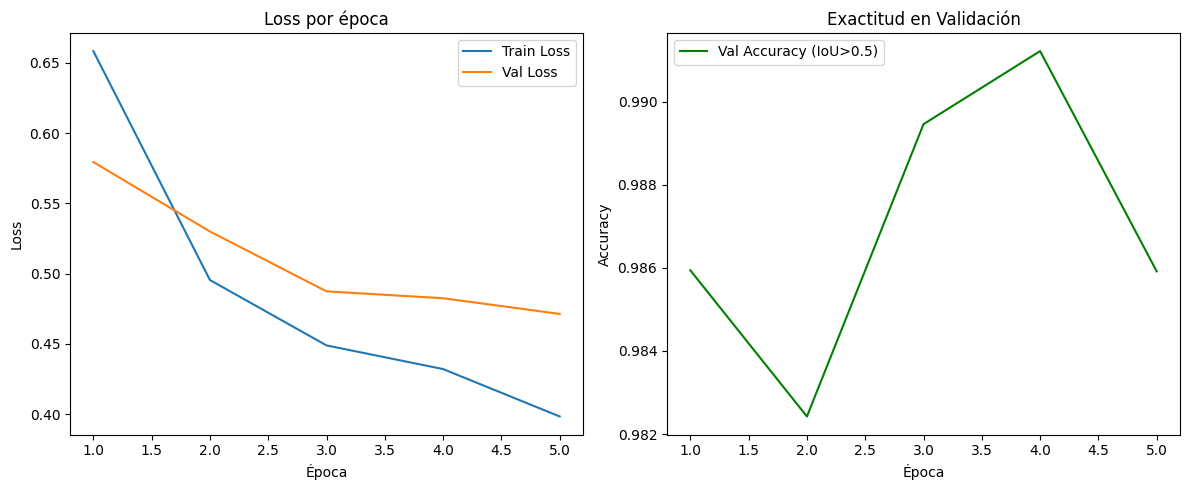

In [ ]:
# Graficar
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('Loss por época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Val Accuracy (IoU>0.5)', color='green')
plt.title('Exactitud en Validación')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
